### Calibration of wave gauge with temperature compensation ###

See other version in D:\Work\_Python3\And0K\tcm_cnv!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from pathlib import Path
import sys
try:
    from ruamel.yaml import YAML
    yaml = YAML()
    yaml.indent(mapping=2, sequence=4, offset=2)
    # yaml.explicit_start=False
except ImportError:
    import yaml

In [2]:
# Load data and column names
filename = r"D:\WorkData\BalticSea\250620_ABP61\t-chain\_raw\calibration\PT@ch_pipe1_ref_SST48mc.txt"
data = np.genfromtxt(filename, delimiter="\t", skip_header=1)
with open(filename) as f:
    header = f.readline().strip().split("\t")

t = data[:, 0]  # Tref
isort_t = np.argsort(t)
p = data[:, 1]  # Prefe
isort_p = np.argsort(p)
i_col_params_st = 2
params = header[i_col_params_st:]  # P and T_A ... T_J

In [3]:
coef_order = [1, 2]

coefs = {i: [] for i in coef_order}
fits = {i: [] for i in coef_order}
for i, param in enumerate(params):
    u = data[:, i_col_params_st + i]  # probe data
    ref = p if i==0 else t
    for order in coef_order:  # each order fit
        coef = np.polyfit(u, ref, order)
        coefs[order].append(coef)
        fits[order].append(np.polyval(coef, u))
        resid = ref - fits[order][i]
        print(f"{i}.order={order}. {param}:", resid, f"={ref}-{fits[order][i]}")


0.order=1. P       : [-0.11423844 -0.08629371  0.20053215] =[ 2.0627536 19.91688   10.04855  ]-[ 2.17699204 20.00317371  9.84801785]
0.order=2. P       : [ 8.88178420e-16 -7.10542736e-15  1.77635684e-15] =[ 2.0627536 19.91688   10.04855  ]-[ 2.0627536 19.91688   10.04855  ]
1.order=1. T_A     : [-0.01187301  0.00831612  0.00355689] =[ 7.53105797  4.750219   14.0953768 ]-[ 7.54293098  4.74190288 14.09181991]
1.order=2. T_A     : [-8.88178420e-16 -3.55271368e-15 -1.77635684e-15] =[ 7.53105797  4.750219   14.0953768 ]-[ 7.53105797  4.750219   14.0953768 ]
2.order=1. T_B     : [-0.01608233  0.01125299  0.00482934] =[ 7.53105797  4.750219   14.0953768 ]-[ 7.5471403   4.73896601 14.09054746]
2.order=2. T_B     : [ 1.77635684e-15 -2.66453526e-15  3.55271368e-15] =[ 7.53105797  4.750219   14.0953768 ]-[ 7.53105797  4.750219   14.0953768 ]
3.order=1. T_C     : [-0.01349416  0.00944791  0.00404625] =[ 7.53105797  4.750219   14.0953768 ]-[ 7.54455213  4.74077109 14.09133055]
3.order=2. T_C     : 

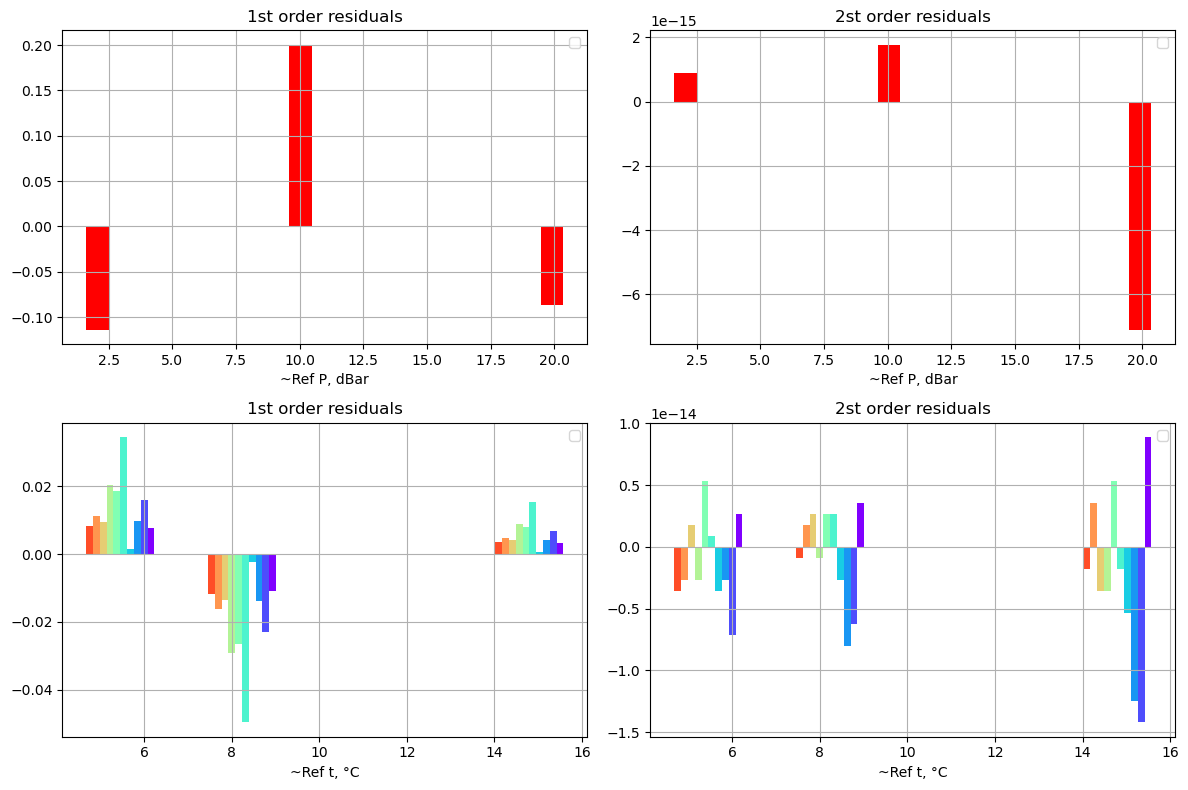

In [ ]:
# Plot

n_ax_rows = i_col_params_st  # number of reference params
i_param_t_st = 1
fig, ax = plt.subplots(n_ax_rows, 2, figsize=(12, 4 * n_ax_rows))

colors = cm.rainbow(np.linspace(0, 1, len(params) + 1 - 1)[::-1])
# reverse colors if last temp lower  # plt.cm.get_cmap().colors

# ptp_p, ptp_t = np.ptp(p), np.ptp(t)  # u_max - u_min, t_max - t_min  # ptp_u = np.ptp()
b_titles_set = False
for i, param in enumerate(params):
    for i_order, order in enumerate(coef_order):  # each order fit
        # u = data[:, i_col_params_st + i]  # probe data
        if i == 0:
            ref = p
            i_ax_row = 0
            x_min, x_max = p.min(), p.max()
            ptp_x = x_max - x_min
            x_shift = 0
            ax[i_ax_row, i_order].legend([params[:i_param_t_st]])
            ax[i_ax_row, i_order].set_xlabel("~Ref P, dBar")
            scale_bar_width = 1 / 20
        elif i == i_param_t_st:  # to not repeat same assignment to t
            ref = t
            i_ax_row = 1
            x_min, x_max = t.min(), t.max()
            ptp_x = x_max - x_min
            x_shift = 0
            ax[i_ax_row, i_order].legend([params[i_param_t_st:]])
            ax[i_ax_row, i_order].set_xlabel("~Ref t, °C")
            scale_bar_width = 1 / 60
        else:
            x_shift = ptp_x * ((i - i_param_t_st) * scale_bar_width)
            b_titles_set = True
        resid = ref - fits[order][i]
        # Plot residuals
        ax[i_ax_row, i_order].bar(
            x=ref + x_shift,
            height=resid,
            width=ptp_x * scale_bar_width,
            color=colors[i % len(colors)],  # , label=param
        )
        if not b_titles_set:
            ax[i_ax_row, i_order].grid()
            ax[i_ax_row, i_order].set_title(f"{order}st order residuals")


# ax.bar(x=[u_min, u_max], height=z_diff, color=c_exp)

# ax3.set_ylabel("P - P_fit, dBar")
# ax.legend(title="mean t ±Δt °C")

plt.tight_layout()
plt.savefig("regression_residuals.png")
plt.show()


In [ ]:
filename = Path(filename)
ax[0, 0].figure.savefig(filename.with_name(f"residuals_fit({filename.stem}).png"))

In [8]:
# Save polynomial coefficients
for order in coef_order:
    with open(filename.with_name(f"coefficients({filename.stem}, order={order}).txt"), "w") as f:
        f.write("probe\tk0\tk1*x\tk2*x^2\n")
        for param, row in zip(params, coefs[order]):
            f.write("\t".join([param] + [str(r) for r in row[::-1]]) + "\n")